In [47]:
import matplotlib.pyplot as plt

import mlflow
import json

import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer

import wandb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline

Fetch the artifact we just created (sample.csv) from W&B and read it with pandas. 

In [48]:
run = wandb.init(project='nyc_airbnb', group="development", job_type="train_random_forest")
local_path = wandb.use_artifact("trainval_data.csv:latest").file()
# df = pd.read_csv(local_path)
# df.head()

In [49]:
X = pd.read_csv(local_path)
y = X.pop("price")  # this removes the column "price" from X and puts it into y

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=X['neighbourhood_group'], random_state=42
)

In [50]:
rf_config = {"n_estimators": 100, "max_depth": 5, "min_samples_split": 4, "min_samples_leaf": 3, \
             "n_jobs": -1, "criterion": "absolute_error", "max_features": 0.33, "oob_score": True}
max_tfidf_features =30
def get_inference_pipeline(rf_config, max_tfidf_features):
    # Let's handle the categorical features first
    # Ordinal categorical are categorical values for which the order is meaningful, for example
    # for room type: 'Entire home/apt' > 'Private room' > 'Shared room'
    ordinal_categorical = ["room_type"]
    non_ordinal_categorical = ["neighbourhood_group"]
    # NOTE: we do not need to impute room_type because the type of the room
    # is mandatory on the websites, so missing values are not possible in production
    # (nor during training). That is not true for neighbourhood_group
    ordinal_categorical_preproc = OrdinalEncoder()

    ######################################
    # Build a pipeline with two steps:
    # 1 - A SimpleImputer(strategy="most_frequent") to impute missing values
    # 2 - A OneHotEncoder() step to encode the variable
    # YOUR CODE HERE
    non_ordinal_categorical_preproc = make_pipeline(
        SimpleImputer(strategy="most_frequent"), OneHotEncoder() 
    )
    ######################################

    # Let's impute the numerical columns to make sure we can handle missing values
    # (note that we do not scale because the RF algorithm does not need that)
    zero_imputed = [
        "minimum_nights",
        "number_of_reviews",
        "reviews_per_month",
        "calculated_host_listings_count",
        "availability_365",
        "longitude",
        "latitude"
    ]
    zero_imputer = SimpleImputer(strategy="constant", fill_value=0)

    # A MINIMAL FEATURE ENGINEERING step:
    # we create a feature that represents the number of days passed since the last review
    # First we impute the missing review date with an old date (because there hasn't been
    # a review for a long time), and then we create a new feature from it,
    date_imputer = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='2010-01-01'),
        FunctionTransformer(delta_date_feature, check_inverse=False, validate=False)
    )

    # Some minimal NLP for the "name" column
    reshape_to_1d = FunctionTransformer(np.reshape, kw_args={"newshape": -1})
    name_tfidf = make_pipeline(
        SimpleImputer(strategy="constant", fill_value=""),
        reshape_to_1d,
        TfidfVectorizer(
            binary=False,
            max_features=max_tfidf_features,
            stop_words='english'
        ),
    )

    # Let's put everything together
    preprocessor = ColumnTransformer(
        transformers=[
            ("ordinal_cat", ordinal_categorical_preproc, ordinal_categorical),
            ("non_ordinal_cat", non_ordinal_categorical_preproc, non_ordinal_categorical),
            ("impute_zero", zero_imputer, zero_imputed),
            ("transform_date", date_imputer, ["last_review"]),
            ("transform_name", name_tfidf, ["name"])
        ],
        remainder="drop",  # This drops the columns that we do not transform
    )

    processed_features = ordinal_categorical + non_ordinal_categorical + zero_imputed + ["last_review", "name"]

    # Create random forest
    random_Forest = RandomForestRegressor(**rf_config)

    # YOUR CODE HERE
    sk_pipe = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("random_forest", random_Forest)
        ]
    )

    return sk_pipe, processed_features


In [51]:
def delta_date_feature(dates):
    """
    Given a 2d array containing dates (in any format recognized by pd.to_datetime), it returns the delta in days
    between each date and the most recent date in its column
    """
    date_sanitized = pd.DataFrame(dates).apply(pd.to_datetime)
    return date_sanitized.apply(lambda d: (d.max() -d).dt.days, axis=0).to_numpy()


In [52]:
sk_pipe, processed_features = get_inference_pipeline(rf_config, max_tfidf_features)

In [53]:
sk_pipe.fit(X_train,y_train)
######################################

# Compute r2 and MAE
r_squared = sk_pipe.score(X_val, y_val)

y_pred = sk_pipe.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

In [54]:
print(mae, r_squared)


35.939468749999996 0.47037907053722505


In [55]:

def plot_feature_importance(pipe, feat_names):
    # We collect the feature importance for all non-nlp features first
    feat_imp = pipe["random_forest"].feature_importances_[: len(feat_names)-1]
    # For the NLP feature we sum across all the TF-IDF dimensions into a global
    # NLP importance
    nlp_importance = sum(pipe["random_forest"].feature_importances_[len(feat_names) - 1:])
    feat_imp = np.append(feat_imp, nlp_importance)
    fig_feat_imp, sub_feat_imp = plt.subplots(figsize=(10, 10))
    # idx = np.argsort(feat_imp)[::-1]
    sub_feat_imp.bar(range(feat_imp.shape[0]), feat_imp, color="r", align="center")
    _ = sub_feat_imp.set_xticks(range(feat_imp.shape[0]))
    _ = sub_feat_imp.set_xticklabels(np.array(feat_names), rotation=90)
    fig_feat_imp.tight_layout()
    return fig_feat_imp


In [56]:
# # signature = mlflow.models.infer_signature(X_val, y_pred)
# mlflow.sklearn.save_model(
#         sk_pipe,
#         "random_forest_dirr",
#         serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_CLOUDPICKLE,
#         # signature=signature,
#         input_example=X_val.iloc[:2]
#     )

In [57]:
run.config.update(rf_config)

wandb: Adding directory to artifact (./random_forest_dir)... Done. 0.2s


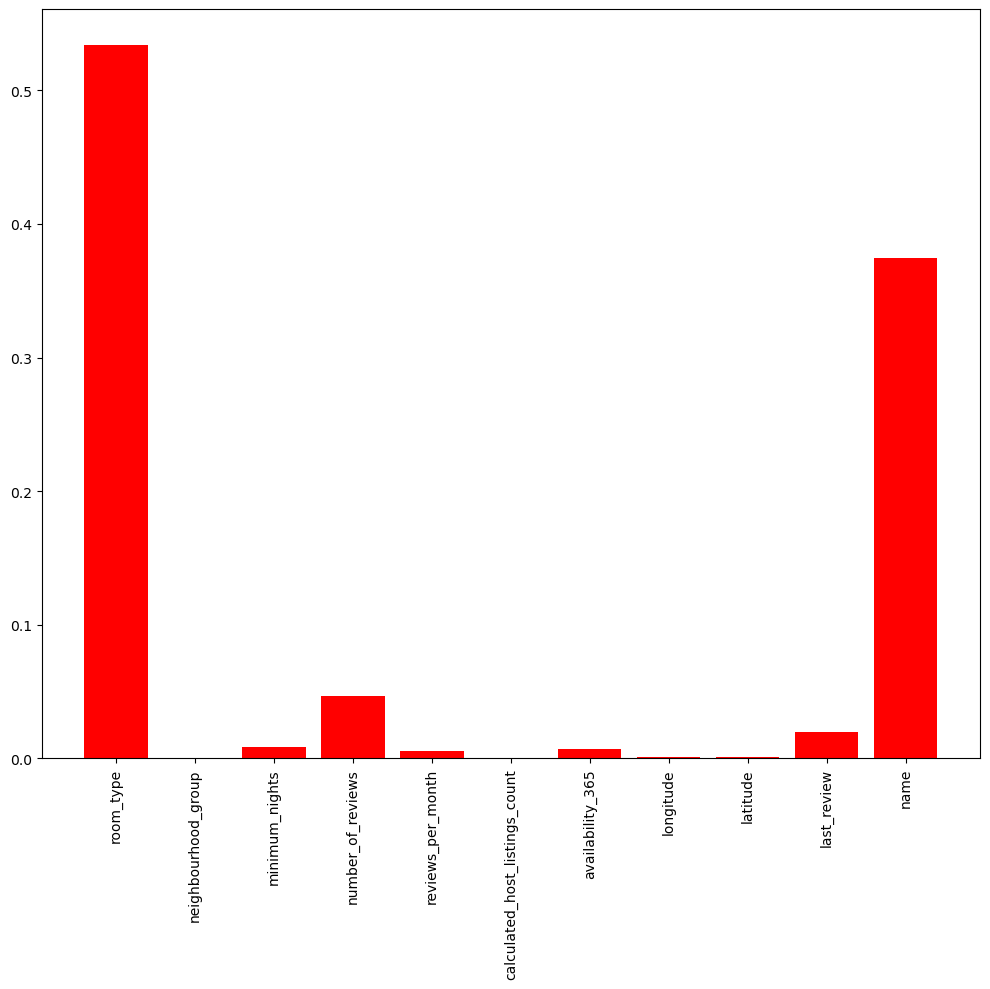

In [58]:
artifact = wandb.Artifact(
        'output_artifact',
        type="model_export",
        description="Random Forest regressor pipeline export",
    )
# artifact.add_dir("random_forest_dir")

run.log_artifact(artifact)

######################################

# Plot feature importance
fig_feat_imp = plot_feature_importance(sk_pipe, processed_features)

######################################
# Here we save r_squared under the "r2" key
run.summary['r2'] = r_squared

# Now log the variable "mae" under the key "mae".
# YOUR CODE HERE
run.summary['mae'] = mae
######################################

# Upload to W&B the feture importance visualization
run.log(
    {
      "feature_importance": wandb.Image(fig_feat_imp),
    }
)

In [59]:
run.finish()

Run pip install nbformat to save notebook history


r2,0.47038
mae,35.93947
_runtime,155
_timestamp,1691715082
_step,0


_runtime,▁
_timestamp,▁
_step,▁
